In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from google.colab import drive

In [7]:
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

#### Adicionando um dataset do tensorflow


In [ ]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split=['train'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incompleteDFBL3V/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [ ]:
for data in dataset[0].take(4):
  print(data)

#### Preparando os dados

In [ ]:
def splits(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

  test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
  return train_dataset, val_dataset, test_dataset

In [ ]:


TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_dataset, val_dataset, test_dataset = splits(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO )

#### Visualizando os dados


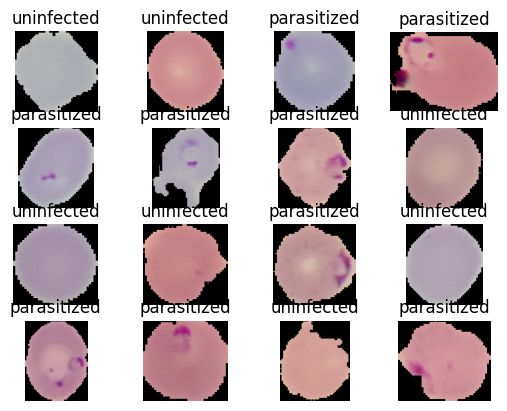

In [ ]:
for i, (image,label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4,4, i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

#### Pré Processando os dados

In [ ]:
IM_SIZE = 224
def resizing_rescale(image, label):
  return tf.image.resize(image, (IM_SIZE,IM_SIZE))/255.0, label

In [ ]:
train_dataset = train_dataset.map(resizing_rescale)
val_dataset = val_dataset.map(resizing_rescale)
test_dataset = test_dataset.map(resizing_rescale)

for image,label in train_dataset.take(1):
  print(image,label)

In [ ]:
BATCH_SIZE = 32
train_dataset = train_dataset.shuffle(buffer_size = 8,
                                      reshuffle_each_iteration = True)\
                                      .batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
val_dataset = val_dataset.shuffle(buffer_size = 8,
                                      reshuffle_each_iteration = True)\
                                      .batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE,3)),

    Conv2D(filters=6, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Conv2D(filters=16, kernel_size=3, strides=1, padding='valid', activation='relu'),
    BatchNormalization(),
    MaxPool2D(pool_size=2, strides=2),

    Flatten(),
    Dense(100, activation='relu'),
    BatchNormalization(),
    Dense(10, activation='relu'),
    BatchNormalization(),
    Dense(1, activation='sigmoid'),
])

lenet_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                        

In [ ]:
y_true = [0,1,0,0]
y_pred = [0.1, 0.91, 0, 0]

bce = tf.keras.losses.BinaryCrossentropy()
bce(y_true, y_pred)

<tf.Tensor: shape=(), dtype=float32, numpy=0.049917735>

In [ ]:
lenet_model.compile(optimizer = Adam(learning_rate = 0.01),
                      loss = BinaryCrossentropy(),
                      metrics = 'accuracy')

In [ ]:
history = lenet_model.fit(train_dataset, validation_data=val_dataset, epochs=20, verbose=1)

Epoch 1/20
689/689 [==============================] - 103s 130ms/step - loss: 0.3431 - accuracy: 0.8538 - val_loss: 0.4618 - val_accuracy: 0.7452
Epoch 2/20
689/689 [==============================] - 75s 109ms/step - loss: 0.2285 - accuracy: 0.9181 - val_loss: 0.3664 - val_accuracy: 0.8962
Epoch 3/20
689/689 [==============================] - 47s 68ms/step - loss: 0.2010 - accuracy: 0.9308 - val_loss: 0.6883 - val_accuracy: 0.8947
Epoch 4/20
689/689 [==============================] - 55s 80ms/step - loss: 0.1822 - accuracy: 0.9391 - val_loss: 0.8894 - val_accuracy: 0.8802
Epoch 5/20
689/689 [==============================] - 48s 70ms/step - loss: 0.1666 - accuracy: 0.9469 - val_loss: 0.2046 - val_accuracy: 0.9499
Epoch 6/20
689/689 [==============================] - 56s 81ms/step - loss: 0.1537 - accuracy: 0.9497 - val_loss: 0.3330 - val_accuracy: 0.9318
Epoch 7/20
689/689 [==============================] - 54s 79ms/step - loss: 0.1463 - accuracy: 0.9520 - val_loss: 0.1555 - val_accura

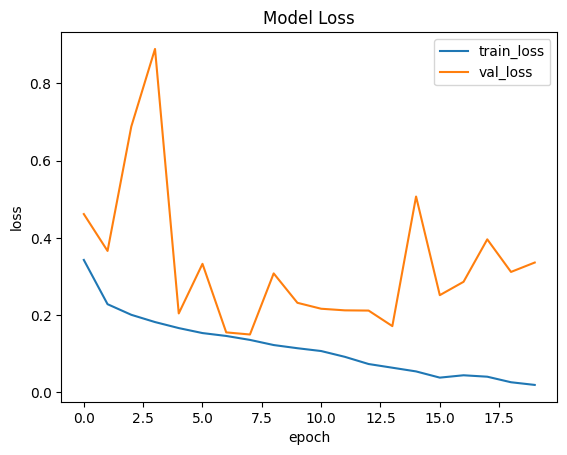

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

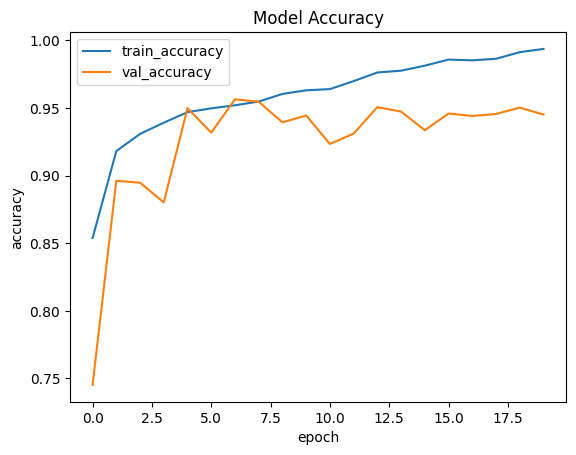

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

In [ ]:
test_dataset = test_dataset.batch(1)
test_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
lenet_model.evaluate(test_dataset)

2757/2757 [==============================] - 23s 4ms/step - loss: 0.3436 - accuracy: 0.9354


[0.34356972575187683, 0.9354370832443237]

In [ ]:
def parasiteOrNot(x):
  if(x < 0.5):
    return str('N')
  else:
    return str('Y')

In [ ]:
parasiteOrNot(lenet_model.predict(test_dataset.take(1))[0][0])

In [ ]:
for i, (image,label) in enumerate(test_dataset.take(9)):
  ax = plt.subplot(3,3,i+1)
  plt.imshow(image[0])
  plt.title(str( parasiteOrNot(label.numpy()[0])) + " : " + str( parasiteOrNot(lenet_model.predict(image)[0][0])))
  plt.axis('off')

#### Salvando e carregando o modelo

In [5]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
lenet_model.save('/content/lenet')

In [ ]:
!mkdir -p /content/lenet/

In [ ]:
!cp -r /content/lenet /content/drive/MyDrive/lenet_colab/

In [6]:
!cp -r /content/drive/MyDrive/lenet_colab/lenet/ /content/lenet

In [ ]:
!rm -rf /content/lenet

In [8]:
lenet_model = load_model('/content/lenet')